# ***MEEN 423 Semester Project***

## Objective:

- Develop a stock market prediction app using Tkinter in Python.
- Utilize TensorFlow and Scikit-learn to implement neural networks and linear regression models.
- Aim to achieve accurate stock market predictions through comprehensive data analysis and model optimization techniques.

## Data Visualization:

Bitcoin-Dataset

Exploring Bitcoin Price Dynamics and Trading Patterns Through Historical Data
https://www.kaggle.com/datasets/jaberimohamedhabib/bitcoin-dataset

In [ ]:
from google.colab import drive

# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Read the data from Excel file
df = pd.read_csv('MSFT (1).csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the Date column
df.sort_values(by='Date', inplace=True)

# Keep the Date and Close columns
df = df[['Date', 'Close']]

# Set index to Date column
df.index = df.pop('Date')

# Visualize data format
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-03-13,415.100006
2024-03-14,425.220001
2024-03-15,416.420013


## Data Splitting, Pre-processing and Model Training:

In [ ]:
import numpy as np
import datetime

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = pd.to_datetime(first_date_str)
  last_date = pd.to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day is 3 days past first day since we are predicting days based on past 3 days
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-30',
                                n=3)

windowed_df


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
252,2022-03-24,299.160004,304.059998,299.489990,304.100006
253,2022-03-25,304.059998,299.489990,304.100006,303.679993
254,2022-03-28,299.489990,304.100006,303.679993,310.700012
255,2022-03-29,304.100006,303.679993,310.700012,315.410004


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

# Convert to matrix for Tensorflow
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((257,), (257, 3, 1), (257,))

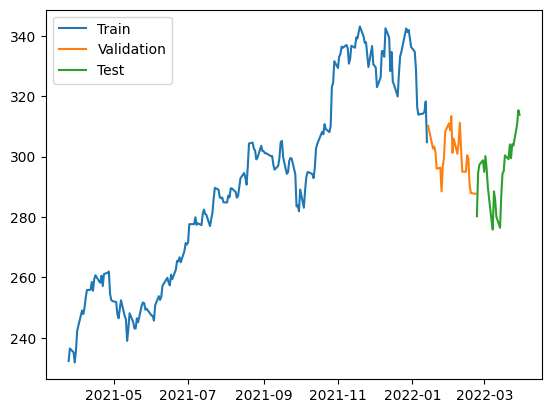

In [ ]:
from matplotlib import pyplot as plt

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 109ms/step - loss: 84636.7344 - mean_absolute_error: 289.1969 - val_loss: 89818.0703 - val_mean_absolute_error: 299.6099
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 84179.3281 - mean_absolute_error: 288.4043 - val_loss: 89360.7969 - val_mean_absolute_error: 298.8458
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 83711.0938 - mean_absolute_error: 287.5924 - val_loss: 88810.3828 - val_mean_absolute_error: 297.9235
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 83128.6719 - mean_absolute_error: 286.5784 - val_loss: 88116.5938 - val_mean_absolute_error: 296.7568
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 82390.5625 - mean_absolute_error: 285.2880 - val_loss: 87216.3281 - val_mean_absolute_error: 295.2361
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 81445.4766 - mean_absolute_error: 283.6291 - val_loss: 861

7/7 [==============================] - 1s 6ms/step


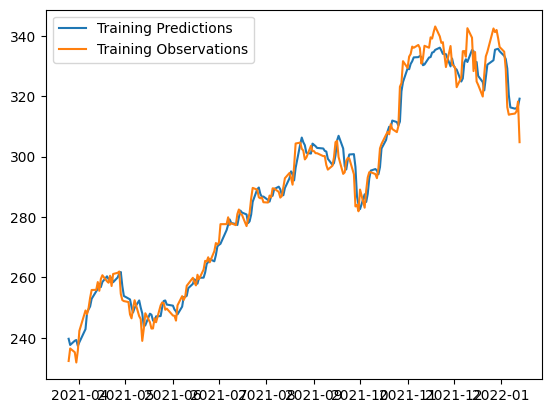

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 29ms/step


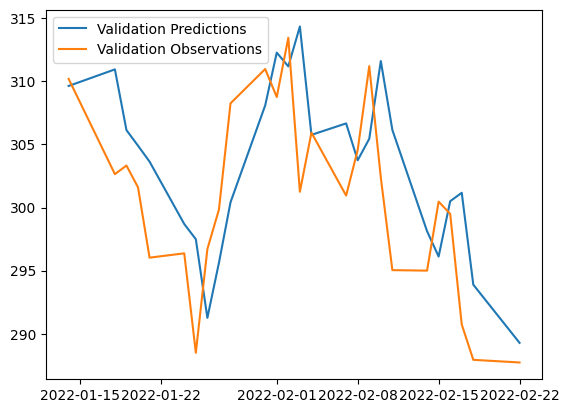

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 29ms/step


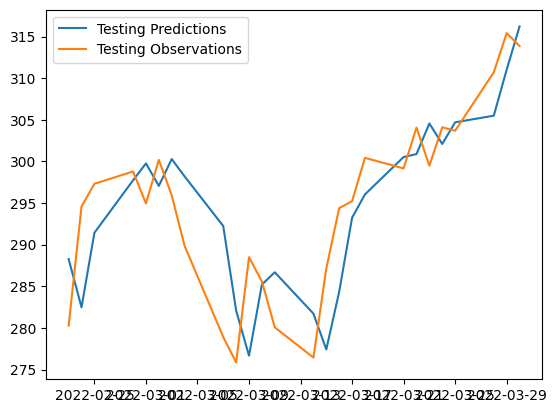

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

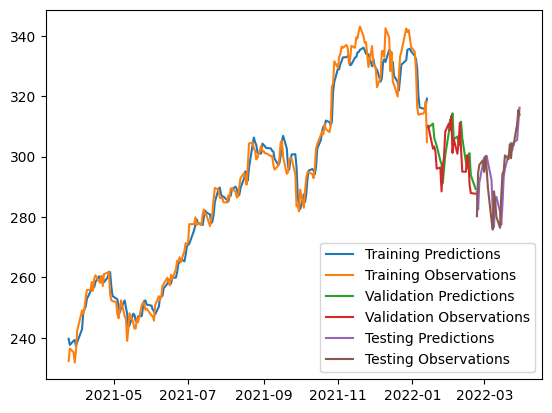

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy
from datetime import timedelta

# Specify the number of days to predict
num_days_to_predict = 40

# Initialize last window with the last window from the test set
last_window = deepcopy(X_test[-1])
recursive_predictions = []
recursive_dates = np.array([dates[-1]])

# Predict for the next num_days_to_predict days
for i in range(num_days_to_predict):
  # Predict the next day's 'Close' price
  next_prediction = model.predict(np.array([last_window])).flatten()

  # Append the prediction to the list of predictions
  recursive_predictions.append(next_prediction)

  # Shift the last window to include the new prediction for the next iteration
  last_window = np.concatenate([last_window[1:], next_prediction.reshape(1, -1)], axis=0)

  # Update the target date to the next day
  target_date = recursive_dates[-1] + timedelta(days=1)

  # Append the target date to the list of dates
  recursive_dates = np.append(recursive_dates, target_date)

recursive_dates = recursive_dates[1:]

1/1 [==============================] - 0s 27ms/step


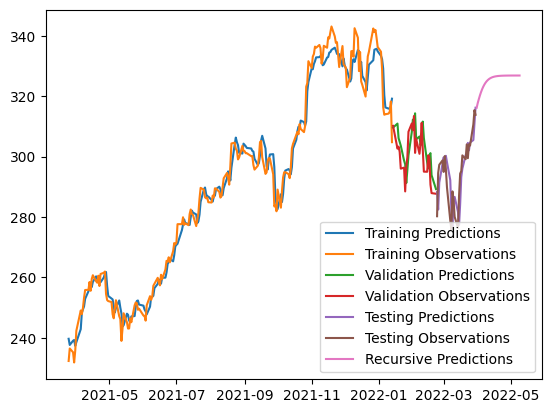

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])